In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                            recall_score, confusion_matrix, roc_curve, auc)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
df = pd.read_parquet("../data/marker_embeddings_subset.parquet")

# Preprocess embeddings and labels
X = np.array(df['embedding'].tolist())  # Convert embeddings to numpy array
y = LabelEncoder().fit_transform(df['marker'])  # Encode labels to 0/1
image_paths = df['image_path'].values

In [11]:
# First split: 80% train+val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define model architecture with reduced dropout (0.2 instead of 0.5)
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),  # Reduced from 0.5
        Dense(32, activation='relu'),
        Dropout(0.1),  # Added another reduced dropout layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize metrics storage and cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
histories = []

In [12]:
for fold, (train_val_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold+1}/5")
    X_trainval, X_test = X[train_val_idx], X[test_idx]
    y_trainval, y_test = y[train_val_idx], y[test_idx]
    
    # Split trainval into train (75%) and val (25%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, 
        test_size=0.25,  # 1 of the 4 trainval folds becomes validation
        stratify=y_trainval,
        random_state=42
    )
    
    # Train with early stopping on validation set
    model = create_model(X.shape[1])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    histories.append(history)
    
    # Evaluate on test set
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_proba = model.predict(X_test).ravel()
    
    # Store metrics
    metrics['acc'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['auc'].append(auc(*roc_curve(y_test, y_proba)[:2]))
    
    # Save last fold for visualization
    if fold == 4:
        last_model = model
        last_data = (X_train, X_val, X_test, y_train, y_val, y_test, y_pred, y_proba)


Fold 1/5


2025-06-23 13:38:25.123548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-23 13:38:25.123605: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-23 13:38:25.123670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-meyerben): /proc/driver/nvidia/version does not exist
2025-06-23 13:38:25.210421: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


In [13]:
# Metrics report
print("\nTest Set Metrics per Fold:")
for metric, values in metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")


Test Set Metrics per Fold:
Acc: 0.9428 ± 0.0093
F1: 0.9426 ± 0.0094
Precision: 0.9454 ± 0.0113
Recall: 0.9401 ± 0.0184
Auc: 0.9897 ± 0.0064


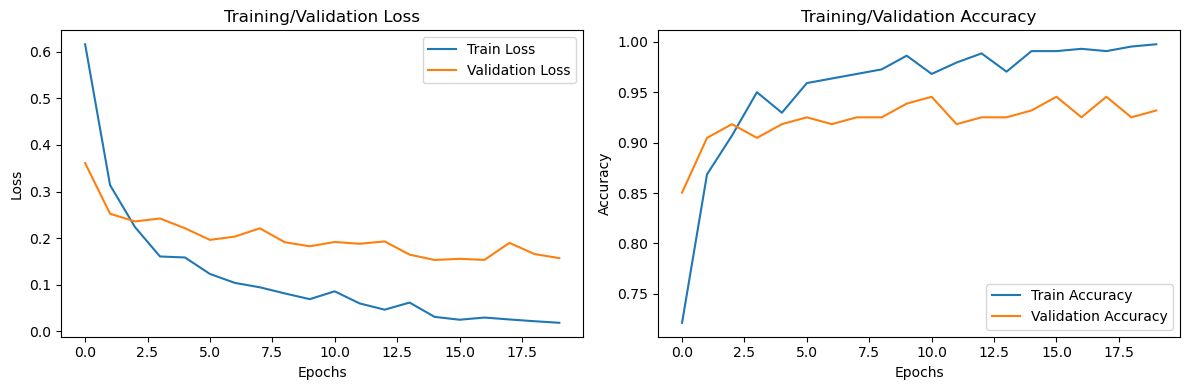

In [14]:
# Visualization (last fold)
X_train, X_val, X_test, y_train, y_val, y_test, y_pred, y_proba = last_data

# 1. Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories[-1].history['loss'], label='Train Loss')
plt.plot(histories[-1].history['val_loss'], label='Validation Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(histories[-1].history['accuracy'], label='Train Accuracy')
plt.plot(histories[-1].history['val_accuracy'], label='Validation Accuracy')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

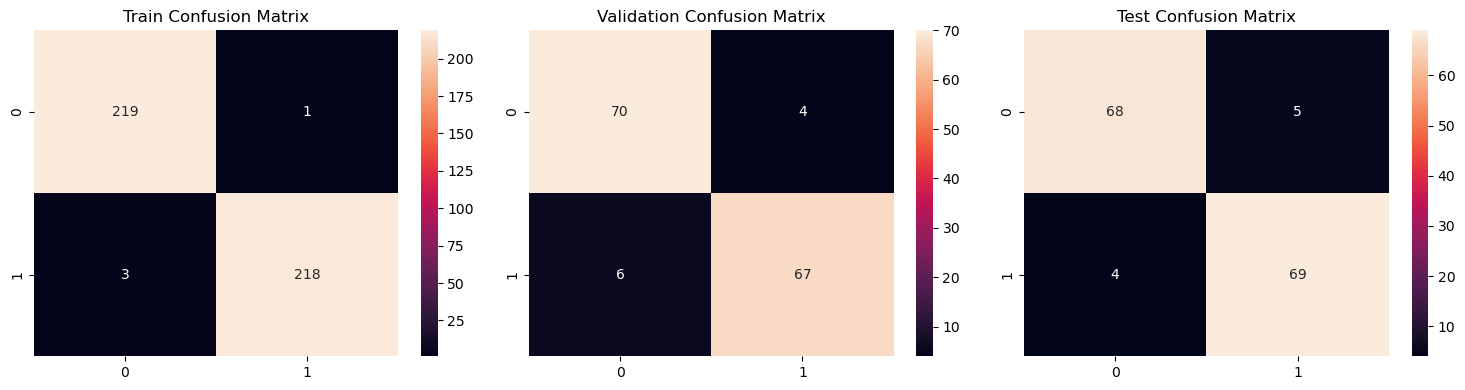

In [15]:
# 2. Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, X_data, y_true) in zip(
    axes, 
    [('Train', X_train, y_train), 
     ('Validation', X_val, y_val), 
     ('Test', X_test, y_test)]
):
    y_pred = (last_model.predict(X_data) > 0.5).astype(int)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

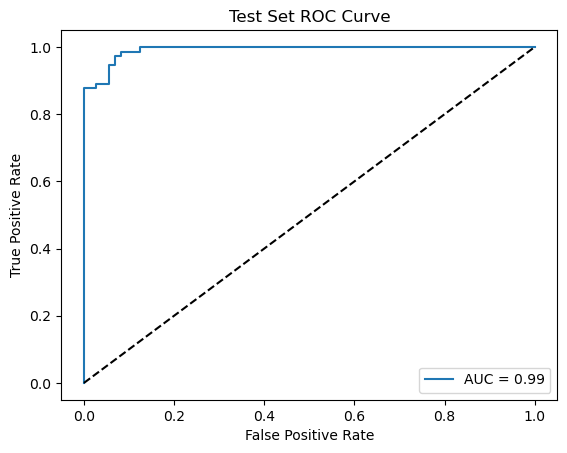

In [16]:
# 3. ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend()
plt.show()

In [17]:
df

image_path  \
0    ../data/images/PAX5/sample_001.png   
1    ../data/images/PAX5/sample_002.png   
2    ../data/images/PAX5/sample_003.png   
3    ../data/images/PAX5/sample_006.png   
4    ../data/images/PAX5/sample_007.png   
..                                  ...   
729   ../data/images/CD3/sample_400.png   
730   ../data/images/CD3/sample_401.png   
731   ../data/images/CD3/sample_402.png   
732   ../data/images/CD3/sample_403.png   
733   ../data/images/CD3/sample_404.png   

                                             embedding marker   sample_id  
0    [4.1601596, 0.19707349, -0.39906776, 0.4187315...   PAX5  sample_001  
1    [2.1713753, -0.18894142, -1.1794543, 0.0642976...   PAX5  sample_002  
2    [2.3522525, 1.3800017, -1.7806236, -1.49976, -...   PAX5  sample_003  
3    [3.3333764, 0.9943014, -0.4116209, 1.0857946, ...   PAX5  sample_006  
4    [3.0457215, 1.0350839, -0.34904912, 1.10828, -...   PAX5  sample_007  
..                                                 ...    ...         ...  
729  [1.2264028, 0.055597667, -0.92955977, -2.60830...    CD3  sample_400  
730  [0.7608712, 1.8352201, 0.3570453, 0.7371291, -...    CD3  sample_401  
731  [1.0764847, -0.42349392, -0.00124115, 0.235760...    CD3  sample_402  
732  [0.8793458, 0.7496702, 0.10183122, -0.8387582,...    CD3  sample_403  
733  [1.1017257, 1.8536514, 0.6336702, 1.3597195, -...    CD3  sample_404  

[734 rows x 4 columns]

# Plotting misclassified images

Processing Fold 1/5...
Processing Fold 2/5...
Processing Fold 3/5...
Processing Fold 4/5...
Processing Fold 5/5...

All Misclassified Examples:


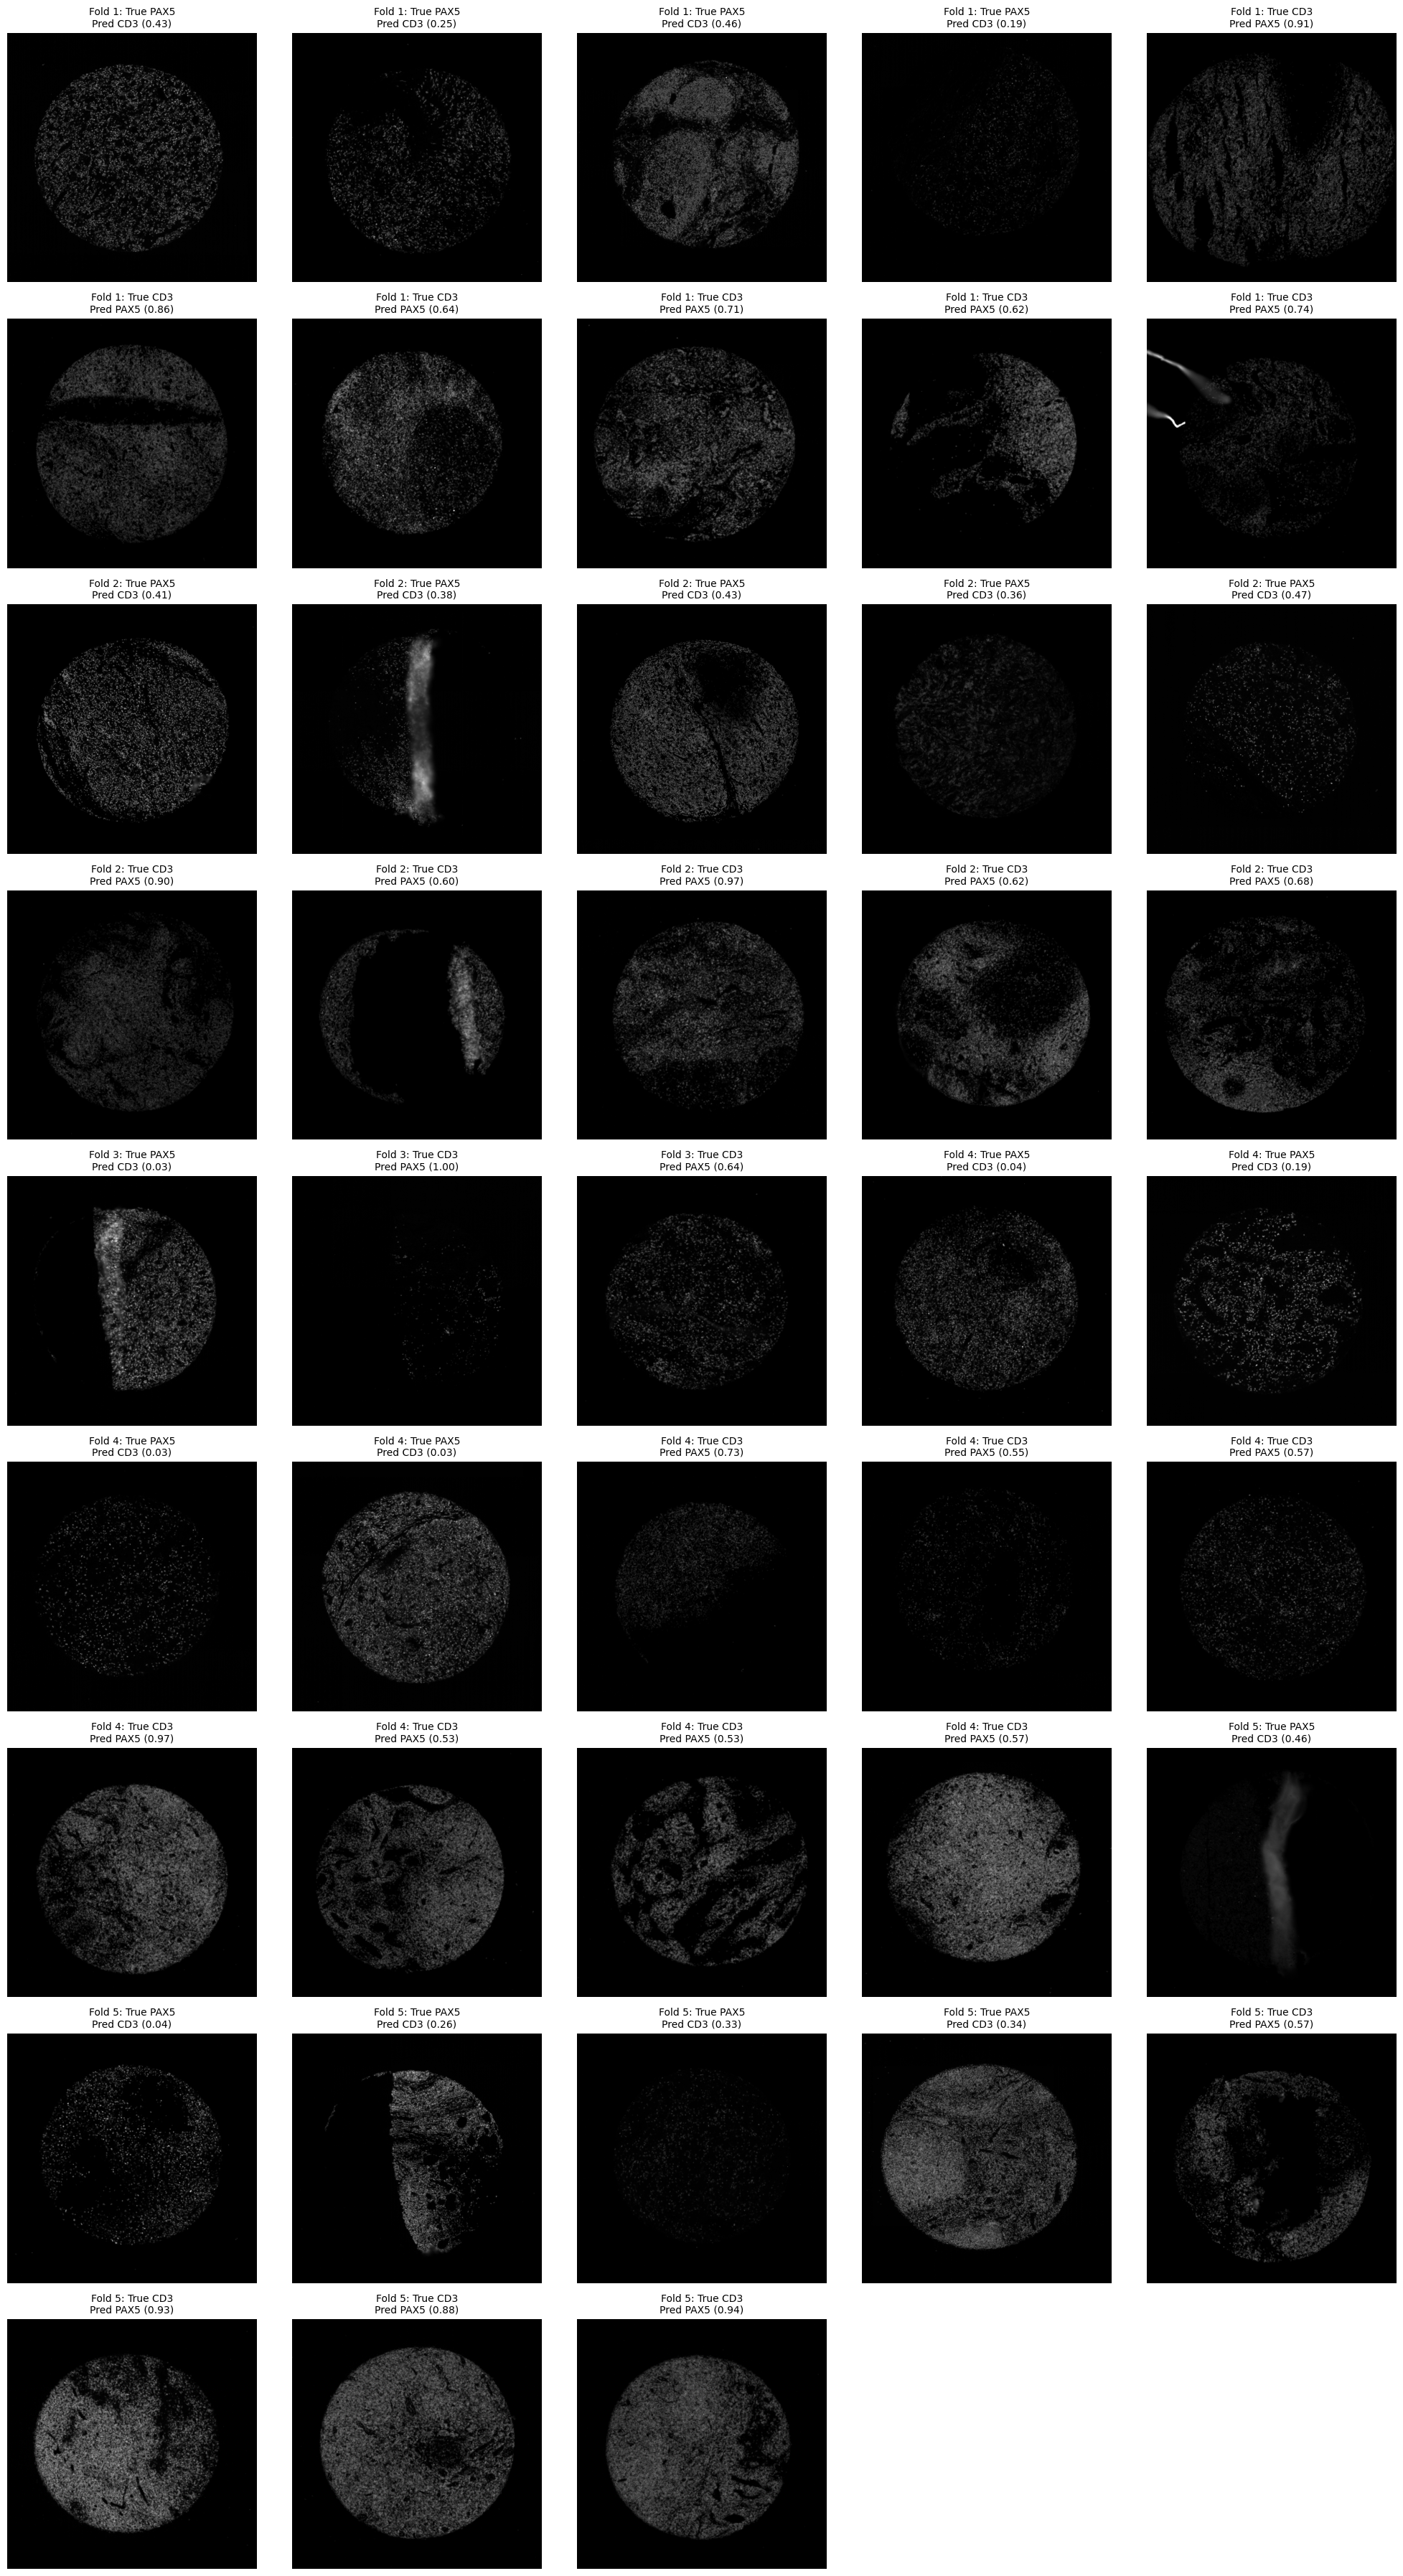


Cross-Validation Accuracy: 0.941 ± 0.020
Total misclassified samples: 43
Error rate: 5.86%


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os

# Load data
df = pd.read_parquet("../data/marker_embeddings_subset.parquet")
X = np.array(df['embedding'].tolist())
y = LabelEncoder().fit_transform(df['marker'])
image_paths = df['image_path'].values

# Model definition
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Storage for misclassified examples
misclassified_samples = []

# 5-fold CV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for fold, (train_val_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"Processing Fold {fold+1}/5...")
    X_trainval, X_test = X[train_val_idx], X[test_idx]
    y_trainval, y_test = y[train_val_idx], y[test_idx]
    test_paths = image_paths[test_idx]
    
    # Split trainval into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)
    
    # Train model
    model = create_model(X.shape[1])
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=100,
              batch_size=32,
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
              verbose=0)
    
    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    fold_accuracy = accuracy_score(y_test, y_pred)
    metrics.append(fold_accuracy)
    
    # Store misclassified examples
    incorrect_mask = (y_pred.flatten() != y_test)
    for i in np.where(incorrect_mask)[0]:
        misclassified_samples.append({
            'fold': fold+1,
            'image_path': test_paths[i],
            'true_label': y_test[i],
            'pred_label': y_pred[i][0],
            'proba': model.predict(X_test[i:i+1])[0][0]
        })

# Final visualization
print("\nAll Misclassified Examples:")
label_names = {0: 'CD3', 1: 'PAX5'}
n_samples = len(misclassified_samples)
n_cols = 5
n_rows = int(np.ceil(n_samples / n_cols))

plt.figure(figsize=(20, 4*n_rows))
for i, sample in enumerate(misclassified_samples):
    try:
        img = cv2.imread(str(sample['image_path']))
        if img is None:
            raise FileNotFoundError
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(f"Fold {sample['fold']}: True {label_names[sample['true_label']]}\n"
            f"Pred {label_names[sample['pred_label']]} ({sample['proba']:.2f})",
            fontsize=10
        )
        plt.axis('off')
    except Exception as e:
        plt.subplot(n_rows, n_cols, i+1)
        plt.text(0.5, 0.5, f"Error loading:\n{os.path.basename(sample['image_path'])}",
                ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print(f"\nCross-Validation Accuracy: {np.mean(metrics):.3f} ± {np.std(metrics):.3f}")
print(f"Total misclassified samples: {len(misclassified_samples)}")
print(f"Error rate: {len(misclassified_samples)/len(df):.2%}")

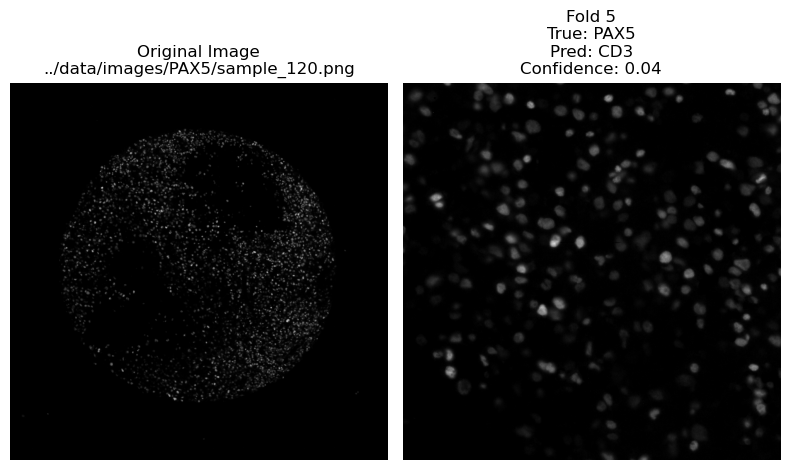

In [51]:
def show_zoomed_misclassification(misclassified_sample, zoom_factor=2.0, figsize=(8, 6)):
    """
    Display a zoomed-in view of a misclassified image with prediction details.
    
    Parameters:
    - misclassified_sample: Dict containing:
        'image_path': Path to the image
        'true_label': Ground truth label (0 or 1)
        'pred_label': Predicted label (0 or 1)
        'proba': Prediction probability
        'fold': (Optional) Fold number where error occurred
    - zoom_factor: How much to zoom in (1.0 = original, 2.0 = 2x zoom)
    - figsize: Figure size in inches
    """
    label_names = {0: 'CD3', 1: 'PAX5'}
    
    try:
        # Load and convert image
        img = cv2.imread(str(misclassified_sample['image_path']))
        if img is None:
            raise FileNotFoundError
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Create zoomed-in region
        zoom_w = int(w / zoom_factor)
        zoom_h = int(h / zoom_factor)
        center_x, center_y = w // 2, h // 2
        zoomed = img[center_y-zoom_h//2:center_y+zoom_h//2, 
                    center_x-zoom_w//2:center_x+zoom_w//2]
        
        # Create figure
        plt.figure(figsize=figsize)
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original Image\n{misclassified_sample['image_path']}")
        plt.axis('off')
        
        # Zoomed image
        plt.subplot(1, 2, 2)
        plt.imshow(zoomed)
        
        # Build title with available info
        title_parts = [
            f"True: {label_names[misclassified_sample['true_label']]}",
            f"Pred: {label_names[misclassified_sample['pred_label']]}",
            f"Confidence: {misclassified_sample['proba']:.2f}"
        ]
        if 'fold' in misclassified_sample:
            title_parts.insert(0, f"Fold {misclassified_sample['fold']}")
            
        plt.title("\n".join(title_parts))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error displaying image: {e}")
        print(f"Problem with file: {misclassified_sample['image_path']}")

# Example usage:
# Pick any misclassified sample from our previous results
if len(misclassified_samples) > 0:
    show_zoomed_misclassification(misclassified_samples[35], zoom_factor=5.0)